In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [3]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [4]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [7]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [8]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [9]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [10]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [11]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [12]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [13]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [14]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [00:30,  3.81it/s]                         


Epoch 1 of 100
Generator loss: 1.51405042, Discriminator loss: 0.43171434


118it [00:30,  3.86it/s]                         


Epoch 2 of 100
Generator loss: 2.51246869, Discriminator loss: 0.77559061


118it [00:30,  3.86it/s]                         


Epoch 3 of 100
Generator loss: 3.27413065, Discriminator loss: 0.28793112


118it [00:30,  3.86it/s]                         


Epoch 4 of 100
Generator loss: 1.96405080, Discriminator loss: 0.41122298


118it [00:30,  3.87it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


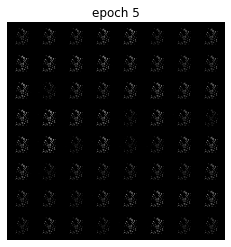

Epoch 5 of 100
Generator loss: 1.26965774, Discriminator loss: 0.55194075


118it [00:30,  3.86it/s]                         


Epoch 6 of 100
Generator loss: 3.69942070, Discriminator loss: 0.50569951


118it [00:30,  3.84it/s]                         


Epoch 7 of 100
Generator loss: 2.34142523, Discriminator loss: 0.58884126


118it [00:30,  3.84it/s]                         


Epoch 8 of 100
Generator loss: 1.12953610, Discriminator loss: 0.67667935


118it [00:30,  3.84it/s]                         


Epoch 9 of 100
Generator loss: 1.62307399, Discriminator loss: 0.57440465


118it [00:30,  3.91it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


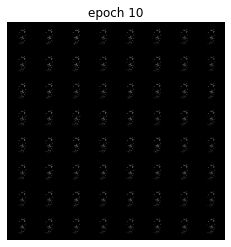

Epoch 10 of 100
Generator loss: 1.10563464, Discriminator loss: 0.57625372


118it [00:30,  3.87it/s]                         


Epoch 11 of 100
Generator loss: 1.68193899, Discriminator loss: 0.50743511


118it [00:30,  3.88it/s]                         


Epoch 12 of 100
Generator loss: 2.01843323, Discriminator loss: 0.55583064


118it [00:30,  3.86it/s]                         


Epoch 13 of 100
Generator loss: 1.39954182, Discriminator loss: 0.54763146


118it [00:31,  3.76it/s]                         


Epoch 14 of 100
Generator loss: 1.10704031, Discriminator loss: 0.44754896


118it [00:31,  3.70it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


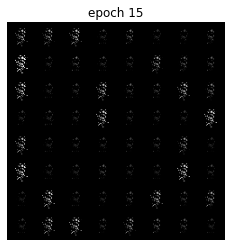

Epoch 15 of 100
Generator loss: 1.70713212, Discriminator loss: 0.48454752


118it [00:31,  3.70it/s]                         


Epoch 16 of 100
Generator loss: 1.76516545, Discriminator loss: 0.43713267


118it [00:31,  3.80it/s]                         


Epoch 17 of 100
Generator loss: 2.71522134, Discriminator loss: 0.44908264


118it [00:31,  3.78it/s]                         


Epoch 18 of 100
Generator loss: 1.74129760, Discriminator loss: 0.44769177


118it [00:31,  3.80it/s]                         


Epoch 19 of 100
Generator loss: 1.44437609, Discriminator loss: 0.46542975


118it [00:31,  3.79it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


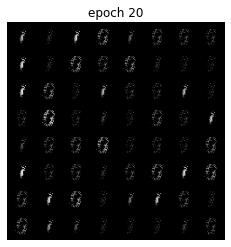

Epoch 20 of 100
Generator loss: 2.22573045, Discriminator loss: 0.42588007


118it [00:31,  3.78it/s]                         


Epoch 21 of 100
Generator loss: 2.24465402, Discriminator loss: 0.33307429


118it [00:31,  3.78it/s]                         


Epoch 22 of 100
Generator loss: 2.31079679, Discriminator loss: 0.29506833


118it [00:31,  3.79it/s]                         


Epoch 23 of 100
Generator loss: 3.07762363, Discriminator loss: 0.28989965


118it [00:31,  3.80it/s]                         


Epoch 24 of 100
Generator loss: 2.75787712, Discriminator loss: 0.27927757


118it [00:30,  3.83it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


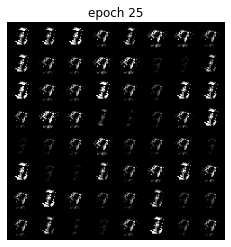

Epoch 25 of 100
Generator loss: 2.58362538, Discriminator loss: 0.28185427


118it [00:31,  3.81it/s]                         


Epoch 26 of 100
Generator loss: 2.92777918, Discriminator loss: 0.24278595


118it [00:30,  3.84it/s]                         


Epoch 27 of 100
Generator loss: 2.68368024, Discriminator loss: 0.24898037


118it [00:30,  3.82it/s]                         


Epoch 28 of 100
Generator loss: 3.55242454, Discriminator loss: 0.24362193


118it [00:31,  3.79it/s]                         


Epoch 29 of 100
Generator loss: 2.75106066, Discriminator loss: 0.30283537


118it [00:31,  3.79it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


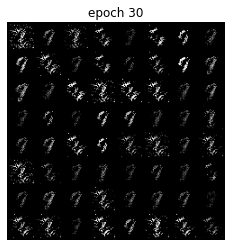

Epoch 30 of 100
Generator loss: 2.92238441, Discriminator loss: 0.24802821


118it [00:31,  3.79it/s]                         


Epoch 31 of 100
Generator loss: 2.75968794, Discriminator loss: 0.30682832


118it [00:31,  3.79it/s]                         


Epoch 32 of 100
Generator loss: 2.86711058, Discriminator loss: 0.32308107


118it [00:31,  3.81it/s]                         


Epoch 33 of 100
Generator loss: 2.52702724, Discriminator loss: 0.26371650


118it [00:30,  3.81it/s]                         


Epoch 34 of 100
Generator loss: 2.97381279, Discriminator loss: 0.22195988


118it [00:31,  3.80it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


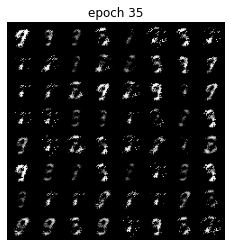

Epoch 35 of 100
Generator loss: 2.90605039, Discriminator loss: 0.25287134


118it [00:31,  3.80it/s]                         


Epoch 36 of 100
Generator loss: 3.09067106, Discriminator loss: 0.21717428


118it [00:30,  3.82it/s]                         


Epoch 37 of 100
Generator loss: 3.34060932, Discriminator loss: 0.22678185


118it [00:31,  3.80it/s]                         


Epoch 38 of 100
Generator loss: 3.68146476, Discriminator loss: 0.18916781


118it [00:30,  3.81it/s]                         


Epoch 39 of 100
Generator loss: 3.91151563, Discriminator loss: 0.17428100


118it [00:31,  3.79it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


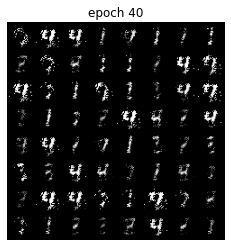

Epoch 40 of 100
Generator loss: 3.56339411, Discriminator loss: 0.21186856


118it [00:31,  3.80it/s]                         


Epoch 41 of 100
Generator loss: 3.47097823, Discriminator loss: 0.22709217


118it [00:30,  3.82it/s]                         


Epoch 42 of 100
Generator loss: 3.24942173, Discriminator loss: 0.20403404


118it [00:30,  3.81it/s]                         


Epoch 43 of 100
Generator loss: 3.73984016, Discriminator loss: 0.18249150


118it [00:30,  3.82it/s]                         


Epoch 44 of 100
Generator loss: 3.37771643, Discriminator loss: 0.25730506


118it [00:31,  3.78it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


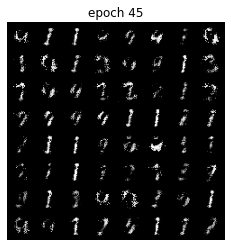

Epoch 45 of 100
Generator loss: 3.38293326, Discriminator loss: 0.17976988


118it [00:30,  3.85it/s]                         


Epoch 46 of 100
Generator loss: 3.30200971, Discriminator loss: 0.20757394


118it [00:31,  3.78it/s]                         


Epoch 47 of 100
Generator loss: 3.19505585, Discriminator loss: 0.22521588


118it [00:30,  3.83it/s]                         


Epoch 48 of 100
Generator loss: 3.44748852, Discriminator loss: 0.21072765


118it [00:30,  3.82it/s]                         


Epoch 49 of 100
Generator loss: 3.45966822, Discriminator loss: 0.19459753


118it [00:30,  3.81it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


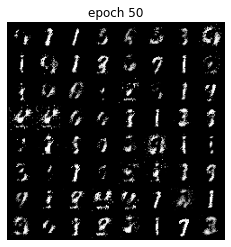

Epoch 50 of 100
Generator loss: 3.21224374, Discriminator loss: 0.23661955


118it [00:30,  3.82it/s]                         


Epoch 51 of 100
Generator loss: 3.25753941, Discriminator loss: 0.21604519


118it [00:30,  3.81it/s]                         


Epoch 52 of 100
Generator loss: 3.01721486, Discriminator loss: 0.21885996


118it [00:30,  3.85it/s]                         


Epoch 53 of 100
Generator loss: 3.15065019, Discriminator loss: 0.22036286


118it [00:30,  3.88it/s]                         


Epoch 54 of 100
Generator loss: 3.22025408, Discriminator loss: 0.22105800


118it [00:30,  3.89it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


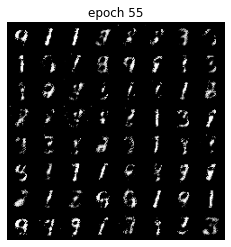

Epoch 55 of 100
Generator loss: 3.44538602, Discriminator loss: 0.21082384


118it [00:30,  3.88it/s]                         


Epoch 56 of 100
Generator loss: 3.28344758, Discriminator loss: 0.22431091


118it [00:30,  3.85it/s]                         


Epoch 57 of 100
Generator loss: 2.99772098, Discriminator loss: 0.22930115


118it [00:30,  3.88it/s]                         


Epoch 58 of 100
Generator loss: 2.95614271, Discriminator loss: 0.22065212


118it [00:30,  3.88it/s]                         


Epoch 59 of 100
Generator loss: 2.99004287, Discriminator loss: 0.21124852


118it [00:30,  3.87it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


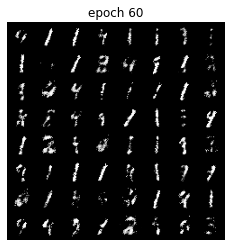

Epoch 60 of 100
Generator loss: 2.94729394, Discriminator loss: 0.22617867


118it [00:30,  3.89it/s]                         


Epoch 61 of 100
Generator loss: 3.06893973, Discriminator loss: 0.23963183


118it [00:30,  3.84it/s]                         


Epoch 62 of 100
Generator loss: 2.99773918, Discriminator loss: 0.25108031


118it [00:30,  3.85it/s]                         


Epoch 63 of 100
Generator loss: 2.79453263, Discriminator loss: 0.28679588


118it [00:30,  3.86it/s]                         


Epoch 64 of 100
Generator loss: 2.71582985, Discriminator loss: 0.29440829


118it [00:30,  3.83it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


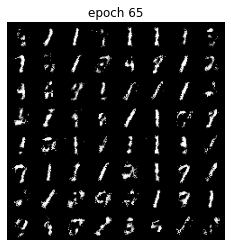

Epoch 65 of 100
Generator loss: 2.71300207, Discriminator loss: 0.26384481


118it [00:30,  3.85it/s]                         


Epoch 66 of 100
Generator loss: 2.96130925, Discriminator loss: 0.23516744


118it [00:30,  3.86it/s]                         


Epoch 67 of 100
Generator loss: 2.86069501, Discriminator loss: 0.25442106


118it [00:30,  3.88it/s]                         


Epoch 68 of 100
Generator loss: 2.73619308, Discriminator loss: 0.27587625


118it [00:30,  3.87it/s]                         


Epoch 69 of 100
Generator loss: 2.71901818, Discriminator loss: 0.27337140


118it [00:30,  3.90it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


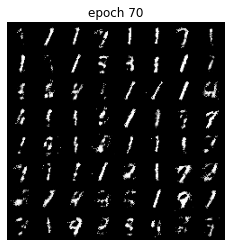

Epoch 70 of 100
Generator loss: 2.69273539, Discriminator loss: 0.25406174


118it [00:30,  3.87it/s]                         


Epoch 71 of 100
Generator loss: 2.65563404, Discriminator loss: 0.25370617


118it [00:30,  3.82it/s]                         


Epoch 72 of 100
Generator loss: 2.65278786, Discriminator loss: 0.27963869


118it [00:32,  3.68it/s]                         


Epoch 73 of 100
Generator loss: 2.66215332, Discriminator loss: 0.27967176


118it [00:31,  3.73it/s]                         


Epoch 74 of 100
Generator loss: 2.69875462, Discriminator loss: 0.26636312


118it [00:31,  3.78it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


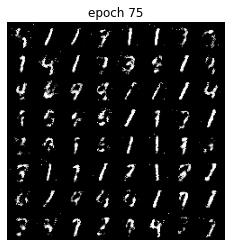

Epoch 75 of 100
Generator loss: 2.63498872, Discriminator loss: 0.28873334


118it [00:30,  3.82it/s]                         


Epoch 76 of 100
Generator loss: 2.52185774, Discriminator loss: 0.30441750


118it [00:30,  3.86it/s]                         


Epoch 77 of 100
Generator loss: 2.52891689, Discriminator loss: 0.29958207


118it [00:30,  3.86it/s]                         


Epoch 78 of 100
Generator loss: 2.55742941, Discriminator loss: 0.28449456


118it [00:30,  3.87it/s]                         


Epoch 79 of 100
Generator loss: 2.59847682, Discriminator loss: 0.29875434


118it [00:30,  3.86it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


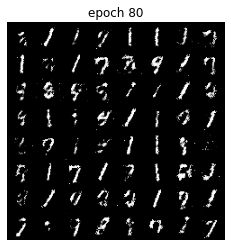

Epoch 80 of 100
Generator loss: 2.50814411, Discriminator loss: 0.29610924


118it [00:30,  3.85it/s]                         


Epoch 81 of 100
Generator loss: 2.43691010, Discriminator loss: 0.30661786


118it [00:30,  3.88it/s]                         


Epoch 82 of 100
Generator loss: 2.41930309, Discriminator loss: 0.31624424


118it [00:30,  3.87it/s]                         


Epoch 83 of 100
Generator loss: 2.33441387, Discriminator loss: 0.31288889


118it [00:30,  3.86it/s]                         


Epoch 84 of 100
Generator loss: 2.33195004, Discriminator loss: 0.31977500


118it [00:30,  3.90it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


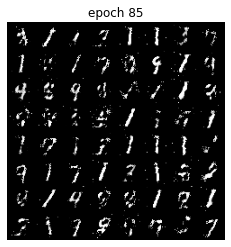

Epoch 85 of 100
Generator loss: 2.25645486, Discriminator loss: 0.34073071


118it [00:47,  2.46it/s]                         


Epoch 86 of 100
Generator loss: 2.36020170, Discriminator loss: 0.33220843


118it [00:51,  2.27it/s]                         


Epoch 87 of 100
Generator loss: 2.33445852, Discriminator loss: 0.31138654


118it [01:21,  1.45it/s]                         


Epoch 88 of 100
Generator loss: 2.44655087, Discriminator loss: 0.29924199


  2%|▏         | 2/117 [00:07<07:03,  3.68s/it]

In [15]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    # fake labels are real for generator cost
    loss_g = criterion(output, label_real(output.size(0)))
    return loss_g

def discriminator_loss(output, true_label):
    loss_d = criterion(output, true_label)
    return loss_d

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        # bi: batch index, data: batch data
        image, _ = data
        # Sample minibatch of m examples {x(1), x(2), · · · , x(m)} from the data
        m = image.size(0) # 512
        image = image.view(m, 784)
        
        # generate fake images
        zs = create_noise(m, nz)
        fake_image = generator(zs).view(m, 784)
        
        # concatinate real and fake images with labels
        real_and_fake_image = torch.cat((image, fake_image))
        image_labels = torch.cat((label_real(m), label_fake(m)))
        
        # forward pass real and fake images through discriminator
        pred_labels = discriminator(real_and_fake_image)
    
        # get discriminator loss
        l = discriminator_loss(pred_labels, image_labels)
        loss_d += l.item()
        
        # backpropation
        discriminator.zero_grad()
        l.backward(retain_graph=True)
        
        # update discriminator weights
        optim_d.step()
        
        # Train the generator
        # get the predictions from discriminator model
        pred_labels = discriminator(fake_image)
        
        # get the generator loss
        l = generator_loss(pred_labels, label_real(m))
        loss_g += l.item()
        
        # backpropagation
        generator.zero_grad()
        l.backward()
        
        # update the weights
        optim_g.step()
                
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [ ]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [ ]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

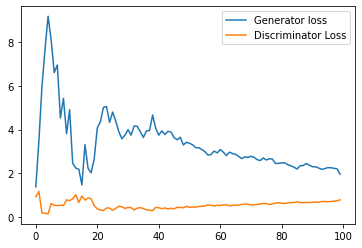

In [ ]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')